In [1]:
import json
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from scipy.special import logsumexp
from copy import deepcopy

from simulation_funs.mchmm_simulator import get_simulation
from mchmm.model_layers.latent_mchmm import _invtrans_rho_parameters
from mchmm import (FullMCHMM, KnownLatentMCHMM)
from mchmm.mchmm import Monitor
from mchmm.known_latent_initializer.initializer_func import initializer_generator as latent_generator
from mchmm.indep_hmm_initializer.initializer_func import initializer_generator as general_generator

2025-07-29 21:33:22.129769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-29 21:33:28.819297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


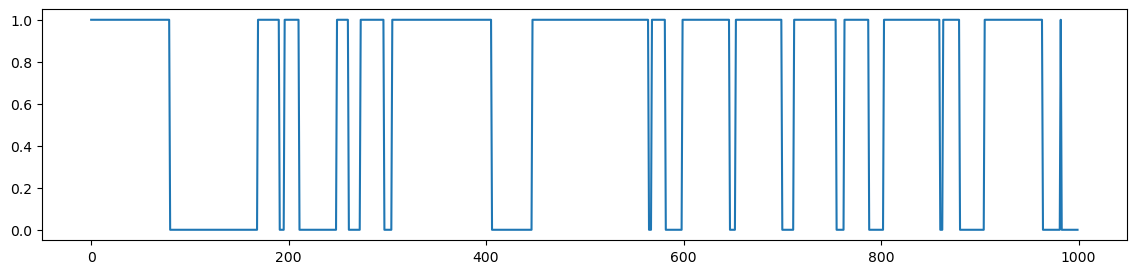

In [3]:
# generator new simulation
with open('simulation_funs/simulation_parameters.json', 'r') as f:
    params_dict = json.load(f)

true_latent, latent_obs, data = get_simulation(params_dict)
fig, ax = plt.subplots(figsize=(14,3))
ax.plot(true_latent)

In [161]:
np.savez('simulated_data.npz', true_latent=true_latent, latent_obs=latent_obs, data=data)

In [5]:
# import stored simulation
import numpy as np

npzfile = np.load('simulated_data.npz')

true_latent = npzfile['true_latent']
latent_obs = npzfile['latent_obs']
data = npzfile['data']


In [138]:
# Fit with known latents
num_states = 2
models_with_latents = []
models_without_rhos = []
for k in [1,2,3]:
    margin_initializer, hmm_initializer, serial_dependence_initializer, \
        cross_sectional_initializer, _ = latent_generator(
            k, num_states, data, true_latent)
    model = KnownLatentMCHMM(k, num_states,
                margin_initializer=margin_initializer,
                hmm_initializer=hmm_initializer,
                serial_dependence_initializer=serial_dependence_initializer,
                cross_sectional_initializer=cross_sectional_initializer)
    model.neg_log_likelihood(data, true_latent, False)

    model.inference_module = model.get_inference_module(data)
    model.complete_monitor = Monitor(len(model._vec_parameters())-4,
                                    -model.neg_log_likelihood(data, true_latent)[0].numpy(),
                                    len(data))
    model.observe_monitor = Monitor(len(model._vec_parameters())-4,
                                    -model.neg_log_observe_likelihood(data)[0].numpy(),
                                    len(data))
    
    models_without_rhos.append(deepcopy(model))
    
    model.constrained_fit(data, true_latent, 5)
    _invtrans_rho_parameters(model.variables[5])
    models_with_latents.append(model)

In [156]:
import numpy as np
np.round(_invtrans_rho_parameters(models_with_latents[2].variables[4]),2)[:,[0,3,5,1,4,2]]

array([[ 0.22,  0.16,  0.15,  0.2 ,  0.15,  0.84],
       [ 0.09,  0.38,  0.08,  0.18,  0.1 , -0.82]])

In [153]:
np.round(_invtrans_rho_parameters(models_with_latents[0].variables[4]),2)

array([[ 0.25,  0.2 ,  0.84,  0.16,  0.14,  0.15],
       [ 0.08,  0.17, -0.82,  0.38,  0.1 ,  0.07]])

In [144]:
from tabulate import tabulate
table_likelihood = [
    ['Markov order'] + [str(i) for i in range(1,4)],
    [r'No correlation when regmies switch'] + [model.complete_monitor.loglik for model in models_without_rhos],
    [r'With correlation when regmies switch'] + [model.complete_monitor.loglik for model in models_with_latents]
]

table_aic = [
    ['Markov order'] + [str(i) for i in range(1,4)],
    [r'No correlation when regmies switch'] + [model.complete_monitor.aic() for model in models_without_rhos],
    [r'With correlation when regmies switch'] + [model.complete_monitor.aic() for model in models_with_latents]
]
table_bic = [
    ['Markov order'] + [str(i) for i in range(1,4)],
    [r'No correlation when regmies switch'] + [model.complete_monitor.bic() for model in models_without_rhos],
    [r'With correlation when regmies switch'] + [model.complete_monitor.bic() for model in models_with_latents]
]
print('\nTable of loglik values:')
print(tabulate(table_likelihood[1:], table_likelihood[0], tablefmt="github"))
print('\nTable of AIC values:')
print(tabulate(table_aic[1:], table_aic[0], tablefmt="github"))
print('\nTable of BIC values')
print(tabulate(table_bic[1:], table_bic[0], tablefmt="github"))


Table of loglik values:
| Markov order                         |        1 |        2 |        3 |
|--------------------------------------|----------|----------|----------|
| No correlation when regmies switch   | -6798.1  | -6805.53 | -6809.81 |
| With correlation when regmies switch | -6784.93 | -6791.32 | -6795.14 |

Table of AIC values:
| Markov order                         |       1 |       2 |       3 |
|--------------------------------------|---------|---------|---------|
| No correlation when regmies switch   | 13706.2 | 13737.1 | 13761.6 |
| With correlation when regmies switch | 13687.9 | 13716.6 | 13740.3 |

Table of BIC values
| Markov order                         |       1 |       2 |       3 |
|--------------------------------------|---------|---------|---------|
| No correlation when regmies switch   | 13976.1 | 14046.2 | 14110.1 |
| With correlation when regmies switch | 13977.4 | 14045.5 | 14108.4 |


In [145]:
print(tabulate(table_aic[1:], table_aic[0], tablefmt="latex"))

\begin{tabular}{lrrr}
\hline
 Markov order                         &       1 &       2 &       3 \\
\hline
 No correlation when regmies switch   & 13706.2 & 13737.1 & 13761.6 \\
 With correlation when regmies switch & 13687.9 & 13716.6 & 13740.3 \\
\hline
\end{tabular}


In [157]:
# Fit without external latents
models = {}
num_states = 2
for sub_ind in [(0,3), (1,3), (2,3)]:
    sub_data = data[:, sub_ind]
    for k in [0,1]:
        margin_initializer, hmm_initializer, initializer_model \
                                = general_generator(num_states, sub_data)
        if k > 0:
            model = FullMCHMM(k=k, num_states=num_states,
                    margin_initializer=margin_initializer,
                    hmm_initializer=hmm_initializer)
            model.neg_log_likelihood(sub_data)
            model.fit(sub_data, display=True, max_iter=500)
        else:
            model = FullMCHMM(k=1, num_states=num_states,
                    margin_initializer=margin_initializer,
                    hmm_initializer=hmm_initializer)
            model.neg_log_likelihood(sub_data)
            model.fit(sub_data, serial_correlated=False, display=True, max_iter=500)
        models[f"{sub_ind!r}_{k}_{num_states}"] = model

Fitting the cross-sectional correlation...
Fitting the within-regime serial dependence...
Fitting the cross-sectional correlation...
Fitting the between-regime serial dependence correlation...


/Users/levin/opt/anaconda3/lib/python3.8/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/levin/opt/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: divide by zero encountered in true_divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/levin/opt/anaconda3/lib/python3.8/site-packages/autograd/core.py:212: RuntimeWarning: invalid value encountered in add
  def _add(self, x, y):        return x + y


Fitting the cross-sectional correlation...
Fitting the within-regime serial dependence...
Fitting the cross-sectional correlation...
Fitting the between-regime serial dependence correlation...
Fitting the cross-sectional correlation...
Fitting the within-regime serial dependence...
Fitting the cross-sectional correlation...
Fitting the between-regime serial dependence correlation...


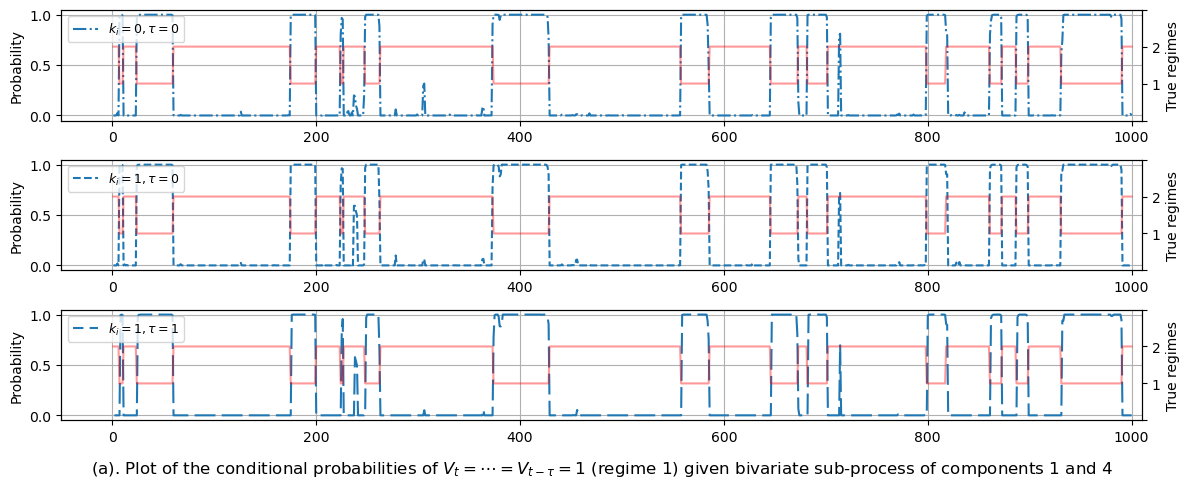

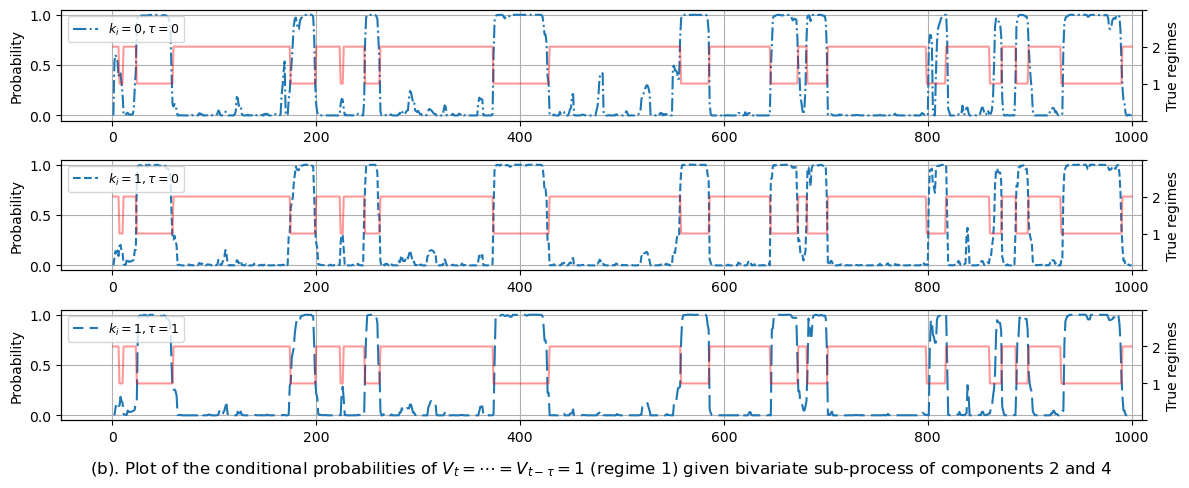

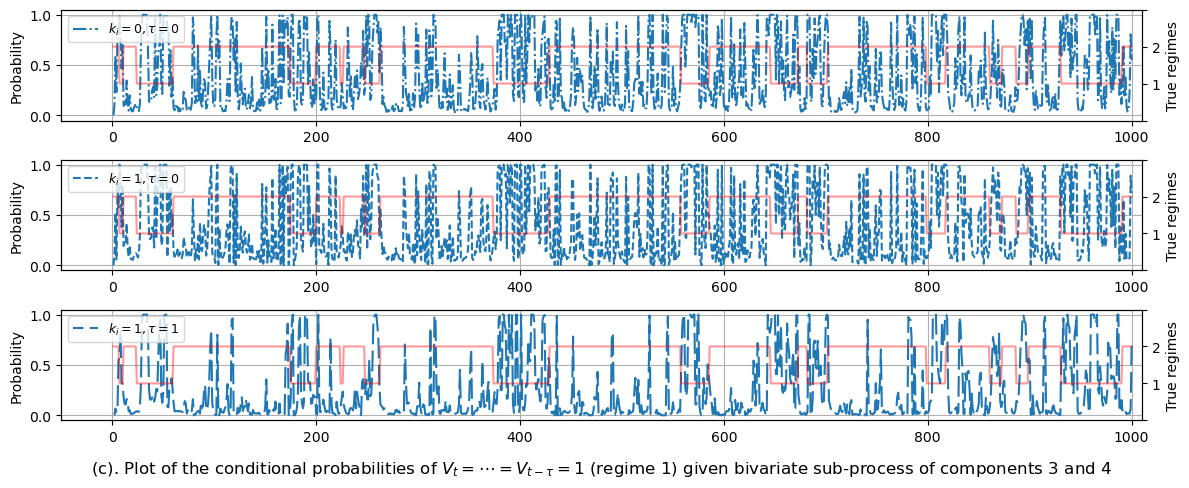

In [158]:
# plot probabilities
for sub_ind in [(0,3), (1,3), (2,3)]:
    p1 = models[f"{sub_ind!r}_0_2"].inference_module.smooth_predict(1)[:,0]
    p2 = models[f"{sub_ind!r}_1_2"].inference_module.smooth_predict(1)[:,0]
    p3 = models[f"{sub_ind!r}_1_2"].inference_module.smooth_predict(2)[:,0,0]

    fig, axs = plt.subplots(nrows=3, figsize=(12,5))
    line0 = axs[0].plot(np.arange(1,1001), p1, label=r'$k_i=0,\tau=0$', linestyle='-.')
    line1 = axs[1].plot(np.arange(1,1001), p2, label=r'$k_i=1,\tau=0$', linestyle='--')
    line2 = axs[2].plot(np.arange(2,1001), p3, label=r'$k_i=1,\tau=1$', linestyle=(5, (10, 3)))
    for ax in axs:
        tax = ax.twinx()
        line3 = tax.plot(np.arange(1,1001), true_latent, color='red', alpha=0.4, label='True regimes')
        tax.set(ylim=[-1,2], 
                yticks=[-1,0,1,2],
                yticklabels=[None, 1, 2, None],
                ylabel='True regimes')
        ax.set_ylabel('Probability')
        ax.grid()
        ax.set_xlim([-50, 1010])
        ax.legend(loc=2, fontsize=9)
    axs[-1].set_title(f'({chr(sub_ind[0]+97)}). Plot of the conditional probabilities of '+r'$V_t=\cdots=V_{t-\tau}=1$ (regime 1)'+f' given bivariate sub-process of components {sub_ind[0]+1} and {sub_ind[1]+1}', y=-0.55)
    fig.tight_layout()
    fig.savefig(f'simulation_plots//subset_{sub_ind[0]}{sub_ind[1]}.pdf')

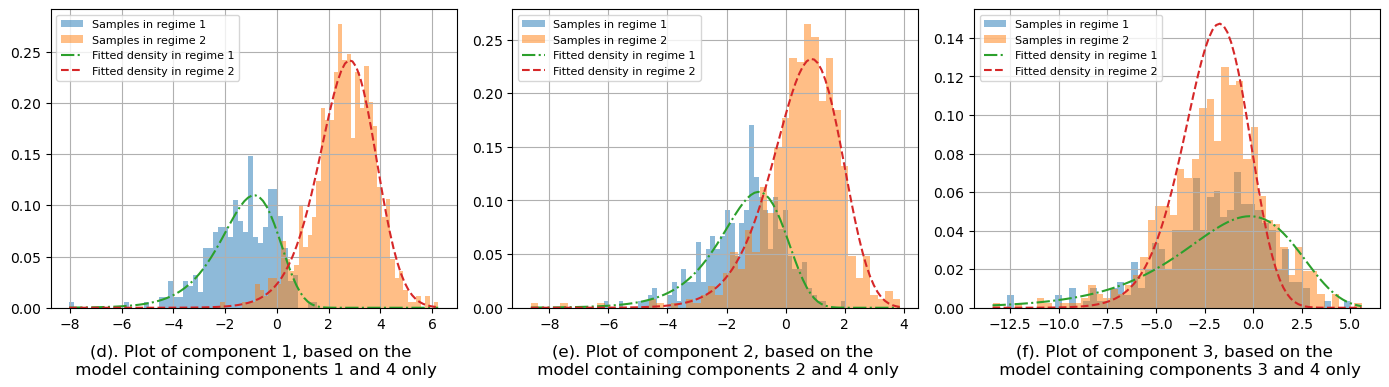

In [159]:
# plot margins
fig, axs = plt.subplots(1, 3, figsize=(14,4))
for i, sub_ind in enumerate([(0,3), (1,3), (2,3)]):
    ax = axs[i]
    select_model = models[f"{sub_ind!r}_1_2"]
    ind = sub_ind[0]

    station_pi = select_model.inference_module.get_pi()
    mgs = [copmg.margins[0] for copmg in select_model.inference_module.copmg_arr]
    vals = np.linspace(min(data[:,ind]), max(data[:,ind]), 100)

    logpdf = np.array([m.logpdf(vals) + np.log(station_pi[i]) 
                                for (i,m) in enumerate(mgs)])
    mlogpdf = logsumexp(logpdf, axis=0)


    density, bins = np.histogram(data[true_latent==0,ind], density=True, bins=50)
    ax.hist(bins[:-1], bins, weights=density*station_pi[0], alpha=0.5,
                label='Samples in regime 1')
    density, bins = np.histogram(data[true_latent==1,ind], density=True, bins=50)
    ax.hist(bins[:-1], bins, weights=density*station_pi[1], alpha=0.5,
                label='Samples in regime 2')
    ax.plot(vals, np.exp(logpdf[0]), linestyle='-.',
                label=f'Fitted density in regime 1')
    ax.plot(vals, np.exp(logpdf[1]), linestyle='--',
                label=f'Fitted density in regime 2')
        #ax.plot(vals, np.exp(mlogpdf), label='Mixture distribution')
    ax.legend(fontsize=8)
    ax.grid()
    ax.set_title(f'({chr(i+100)}). Plot of component {sub_ind[0]+1}, based on the \n model containing components {sub_ind[0]+1} and 4 only', y=-0.25)
fig.tight_layout()
fig.savefig(r'simulation_plots/densities.pdf')


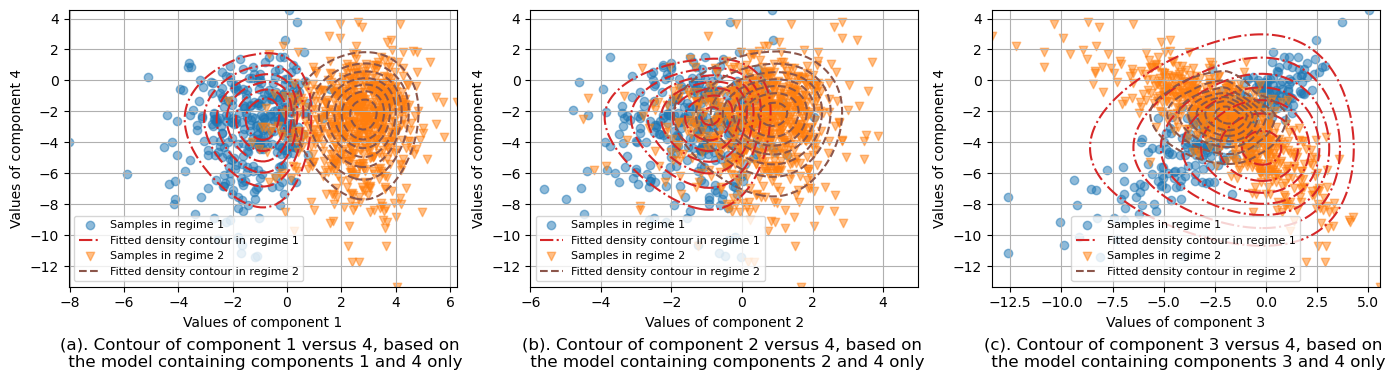

In [160]:
from plot_funcs import get_contour_arrays
fig, axs = plt.subplots(1, 3, figsize=(14,4))
for i, sub_ind in enumerate([(0,3), (1,3), (2,3)]):
    select_model = models[f"{sub_ind!r}_1_2"]

    ax = axs[i]
    style = ['dashdot', 'dashed']
    color = [3,5]
    markers = ['o', 'v']
    legend_lines = []
    for r in [0,1]:
        mg1 = select_model.inference_module.copmg_arr[r].margins[0]
        vals1 = np.linspace(min(data[:,sub_ind[0]]), max(data[:,sub_ind[0]]), 100)
        mg2 = select_model.inference_module.copmg_arr[r].margins[1]
        vals2 = np.linspace(min(data[:,sub_ind[1]]), max(data[:,sub_ind[1]]), 100)
        rho = select_model.inference_module.mc_corr_arr[r].par_arr[0, 1]
        xx, yy, zz = get_contour_arrays(mg1, mg2, rho, vals1, vals2)
        ax.scatter(data[true_latent==r, sub_ind[0]],
                   data[true_latent==r, sub_ind[1]],
                   marker=markers[r], alpha=0.5, label=f'Samples in regime {r+1}')
        ax.contour(xx, yy, zz, colors=f'C{color[r]}', linestyles=style[r])
        ax.plot([1], [2], color=f'C{color[r]}', linestyle=style[r], 
            label=f'Fitted density contour in regime {r+1}')

    ax.legend(fontsize=8)
    ax.grid()
    ax.set(xlabel=f'Values of component {sub_ind[0]+1}',
            ylabel=f'Values of component {sub_ind[1]+1}')
    ax.set_title(f'({chr(i+97)}). Contour of component {sub_ind[0]+1} versus {sub_ind[1]+1}, based on \n the model containing components {sub_ind[0]+1} and {sub_ind[1]+1} only', y=-0.32)
    if i==1: ax.set(xlim=[-6, 5])
fig.tight_layout()
fig.savefig(r'simulation_plots/contours.pdf')

In [6]:
from tqdm import tqdm
num_states = 2
models_with_latents = {1:[], 2:[]}
models_without_rhos = {1:[], 2:[]}
for i in tqdm(range(5)):
    true_latent, latent_obs, data = get_simulation(params_dict)
    for k in [1,2]:
        margin_initializer, hmm_initializer, serial_dependence_initializer, \
            cross_sectional_initializer, _ = latent_generator(
                k, num_states, data, true_latent)
        model = KnownLatentMCHMM(k, num_states,
                    margin_initializer=margin_initializer,
                    hmm_initializer=hmm_initializer,
                    serial_dependence_initializer=serial_dependence_initializer,
                    cross_sectional_initializer=cross_sectional_initializer)
        model.neg_log_likelihood(data, true_latent, False)
        model.inference_module = model.get_inference_module(data)
        model.complete_monitor = Monitor(len(model._vec_parameters())-4,
                                        -model.neg_log_likelihood(data, true_latent)[0].numpy(),
                                        len(data))
        model.observe_monitor = Monitor(len(model._vec_parameters())-4,
                                        -model.neg_log_observe_likelihood(data)[0].numpy(),
                                        len(data))

        models_without_rhos[k].append(deepcopy(model))

        model.constrained_fit(data, true_latent, 5)
        models_with_latents[k].append(model)
        np.savez(f"saved_parameters/simulated_params/fit_simulation_params_{i}_{k}.npz", 
                 params=model._vec_parameters())

  0%|          | 0/5 [00:00<?, ?it/s]

Current alpha is 1.0
The starting point is [0.3084168  0.25478028 0.76914605 0.1082721  0.1807889  0.1874156 ]
Current alpha is 1.0
The starting point is [ 0.13787798  0.25088385 -0.76624948  0.34698219  0.08098435  0.20848299]
Current alpha is 1.0
The starting point is [0.30856687 0.25470629 0.7691465  0.10821797 0.18087015 0.1873195 ]
Current alpha is 1.0
The starting point is [ 0.13786548  0.25087845 -0.76626577  0.34698529  0.08098305  0.20843337]


 20%|██        | 1/5 [04:44<18:58, 284.53s/it]

Current alpha is 1.0
The starting point is [0.35699612 0.32655402 0.80947121 0.1149229  0.26031333 0.13018453]
Current alpha is 1.0
The starting point is [ 0.0924673   0.1407901  -0.77491963  0.39129231  0.1822086   0.14735416]
Current alpha is 1.0
The starting point is [0.35703813 0.32676998 0.8094642  0.11496193 0.26047157 0.13023744]
Current alpha is 1.0
The starting point is [ 0.09247019  0.14079111 -0.77491871  0.39127756  0.18221821  0.14735458]


 40%|████      | 2/5 [10:13<15:31, 310.49s/it]/Users/levin/Desktop/others/margin_closed_hmm/margin_closed_hmm/mchmm/known_latent_initializer/external_info_univariate_model.py:191: RuntimeWarning: invalid value encountered in double_scalars
  logpdf = -0.5 * np.log(np.linalg.det(R)) \


Current alpha is 1.0
The starting point is [0.2967391  0.33675873 0.8031545  0.20947429 0.23762865 0.15314611]
Current alpha is 1.0
The starting point is [ 0.16906984  0.21756309 -0.7710573   0.42196877  0.14155827  0.1191009 ]
Current alpha is 1.0
The starting point is [0.2966659  0.33686718 0.80311872 0.20918418 0.23763175 0.15309142]
Current alpha is 1.0
The starting point is [ 0.16908284  0.21756293 -0.77103292  0.42201406  0.14162347  0.1191592 ]


 60%|██████    | 3/5 [14:26<09:28, 284.28s/it]

Current alpha is 1.0
The starting point is [0.23398723 0.34648852 0.77748406 0.32525063 0.2380657  0.32349824]
Current alpha is 1.0
The starting point is [ 0.05269032  0.22078997 -0.80934092  0.43097235  0.03562937  0.04917088]
Current alpha is 1.0
The starting point is [0.2341063  0.34648038 0.77751611 0.32545841 0.23746518 0.32275843]
Current alpha is 1.0
The starting point is [ 0.05270897  0.2207981  -0.80933889  0.43100152  0.03562983  0.04914879]


 80%|████████  | 4/5 [19:28<04:51, 291.53s/it]

Current alpha is 1.0
The starting point is [0.26433068 0.18348773 0.79522745 0.1858554  0.06210907 0.22623668]
Current alpha is 1.0
The starting point is [ 0.11526443  0.17855115 -0.794259    0.41394374  0.14936659  0.08450637]
Current alpha is 1.0
The starting point is [0.26433123 0.18341964 0.79520389 0.18588472 0.06209719 0.22624569]
Current alpha is 1.0
The starting point is [ 0.11526539  0.17854788 -0.79426022  0.41394692  0.1493764   0.08452385]


100%|██████████| 5/5 [25:05<00:00, 301.09s/it]


In [78]:
estimates = []
for model in models_with_latents[1]:
    param = []
    param += _invtrans_rho_parameters(model.variables[3]).numpy().ravel().tolist()
    param += _invtrans_rho_parameters(model.variables[4]).numpy()[:,[0,3,5,1,4,2]].ravel().tolist()
    param += _invtrans_rho_parameters(model.variables[5]).numpy().ravel().tolist()
    estimates.append(np.array(param))

print(np.round(np.array(estimates).mean(axis=0),2))
print(np.round(np.array(estimates).std(axis=0),2))

[ 0.3   0.09  0.29  0.1   0.49  0.09  0.49  0.09  0.3   0.19  0.18  0.3
  0.2   0.79  0.1   0.4   0.1   0.2   0.1  -0.8   0.1   0.19  0.1   0.19]
[0.05 0.04 0.06 0.03 0.05 0.04 0.04 0.04 0.05 0.06 0.06 0.06 0.06 0.02
 0.04 0.03 0.04 0.04 0.04 0.01 0.07 0.11 0.04 0.04]


In [79]:
estimates = []
for model in models_with_latents[2]:
    param = []
    param += _invtrans_rho_parameters(model.variables[3]).numpy().ravel().tolist()
    param += _invtrans_rho_parameters(model.variables[4]).numpy()[:,[0,3,5,1,4,2]].ravel().tolist()
    param += _invtrans_rho_parameters(model.variables[5]).numpy().ravel().tolist()
    estimates.append(np.array(param))

print(np.round(np.array(estimates).mean(axis=0),2))
print(np.round(np.array(estimates).std(axis=0),2))

[ 0.3  -0.01  0.09 -0.    0.29 -0.01  0.1  -0.    0.49  0.    0.09 -0.
  0.49  0.    0.09 -0.    0.3   0.19  0.18  0.3   0.2   0.79  0.1   0.39
  0.1   0.2   0.1  -0.8   0.09  0.18  0.11  0.19]
[0.05 0.06 0.04 0.04 0.06 0.07 0.03 0.04 0.05 0.06 0.04 0.04 0.04 0.06
 0.04 0.04 0.05 0.06 0.06 0.06 0.06 0.02 0.04 0.03 0.04 0.04 0.04 0.01
 0.07 0.12 0.04 0.04]


In [86]:
aics = []
for model in models_with_latents[1]:
    aics.append(model.complete_monitor.aic()/1000)
print(np.mean(aics))
print(np.std(aics))

13.705183106285743
0.11339797357861163


In [87]:
aics = []
for model in models_with_latents[2]:
    aics.append(model.complete_monitor.aic()/1000)
print(np.mean(aics))
print(np.std(aics))

13.730528954460025
0.1146150126138076


In [88]:
aics = []
for model in models_without_rhos[1]:
    aics.append(model.complete_monitor.aic()/1000)
print(np.mean(aics))
print(np.std(aics))


13.738279159134256
0.11614869025778336


In [89]:
aics = []
for model in models_without_rhos[2]:
    aics.append(model.complete_monitor.aic()/1000)
print(np.mean(aics))
print(np.std(aics))

13.76145505786031
0.1167125943201216
